In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv(r'E:\vinay\dataset\titanic\titanic.csv')

In [3]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## **1. Exploratory Data Analysis**

### **1.1 Overview**
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [4]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
70,71,0,2,"Jenkin, Mr. Stephen Curnow",male,32.0,0,0,C.A. 33111,10.5000,NaN,S
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C
568,569,0,3,"Doharr, Mr. Tannous",male,NaN,0,0,2686,7.2292,NaN,C


### **1.2 Missing Values**
As seen from below, some columns have missing values. `display_missing` function shows the count of missing values in every column in training set.
* Training set have missing values in `Age`, `Cabin` and `Embarked` columns
It is convenient to work on concatenated training set while dealing with missing values, otherwise filled data may overfit to training set samples. The count of missing values in `Age`, `Embarked` and `Fare` are smaller compared to total sample, but roughly **80%** of the `Cabin` is missing. Missing values in `Age`, `Embarked` and `Fare` can be filled with descriptive statistical measures but that wouldn't work for `Cabin`.

In [5]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
def display_missing(df):
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))

display_missing(df_train)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


#### **1.2.1 Age**
Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)**. It is also more logical to group ages by passenger classes instead of other features.

In [7]:
df_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'Age']

C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\2630976805.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()


,Feature 1,Feature 2,Correlation Coefficient
5,Age,Age,1.000000
12,Age,Pclass,0.369226
16,Age,SibSp,0.308247
21,Age,Parch,0.189119
26,Age,Fare,0.096067
32,Age,Survived,0.077221
36,Age,PassengerId,0.036847


In [8]:
age_pclass_sex = df_train.groupby(['Sex','Pclass']).median()['Age']
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print(f"Median age of Pclass {pclass} {sex}s: {age_pclass_sex[sex][pclass]}")
print(f"median age of all passengers: {df_train['Age'].median()}")
#filling in the missing values in age with the medians of sex and pclass groups
df_train['Age'] = df_train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 35.0
Median age of Pclass 1 males: 40.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 30.0
Median age of Pclass 3 females: 21.5
Median age of Pclass 3 males: 25.0
median age of all passengers: 28.0


C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\2495269510.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  age_pclass_sex = df_train.groupby(['Sex','Pclass']).median()['Age']
C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\2495269510.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_train['Age'] = df_train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))


#### **1.2.2 Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [9]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


When I googled **Stone, Mrs. George Nelson (Martha Evelyn)**, I found that she embarked from **S (Southampton)** with her maid **Amelie Icard**, in this page [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).

> *Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*

Missing values in `Embarked` are filled with **S** with this information.

In [10]:
#filling the missing values in embarked with S
df_train['Embarked']=df_train['Embarked'].fillna('S')

In [11]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
#df_train[df_train['Fare'].isnull()]

#### **1.2.4 Cabin**
`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

In [14]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_train['Deck']= df_train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_train['Deck'].sample(5)

781    B
205    G
28     M
741    C
6      E
Name: Deck, dtype: object

In [15]:
df_train_decks = df_train.groupby(['Deck', 'Pclass'])
df_train_decks.count()

PassengerId  Survived  Name  Sex  Age  SibSp  Parch  Ticket  \
Deck Pclass                                                                
A    1                15        15    15   15   15     15     15      15   
B    1                47        47    47   47   47     47     47      47   
C    1                59        59    59   59   59     59     59      59   
D    1                29        29    29   29   29     29     29      29   
     2                 4         4     4    4    4      4      4       4   
E    1                25        25    25   25   25     25     25      25   
     2                 4         4     4    4    4      4      4       4   
     3                 3         3     3    3    3      3      3       3   
F    2                 8         8     8    8    8      8      8       8   
     3                 5         5     5    5    5      5      5       5   
G    3                 4         4     4    4    4      4      4       4   
M    1                40        40    40   40   40     40     40      40   
     2               168       168   168  168  168    168    168     168   
     3               479       479   479  479  479    479    479     479   
T    1                 1         1     1    1    1      1      1       1   

             Fare  Cabin  Embarked  
Deck Pclass                         
A    1         15     15        15  
B    1         47     47        47  
C    1         59     59        59  
D    1         29     29        29  
     2          4      4         4  
E    1         25     25        25  
     2          4      4         4  
     3          3      3         3  
F    2          8      8         8  
     3          5      5         5  
G    3          4      4         4  
M    1         40      0        40  
     2        168      0       168  
     3        479      0       479  
T    1          1      1         1

In [16]:
df_all_decks = df_train.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

df_all_decks

Deck     A   B   C   D      E        F     G   M            T
Pclass   1   1   1   1  2   1  2  3  2  3  3   1    2    3  1
Count   15  47  59  29  4  25  4  3  8  5  4  40  168  479  1

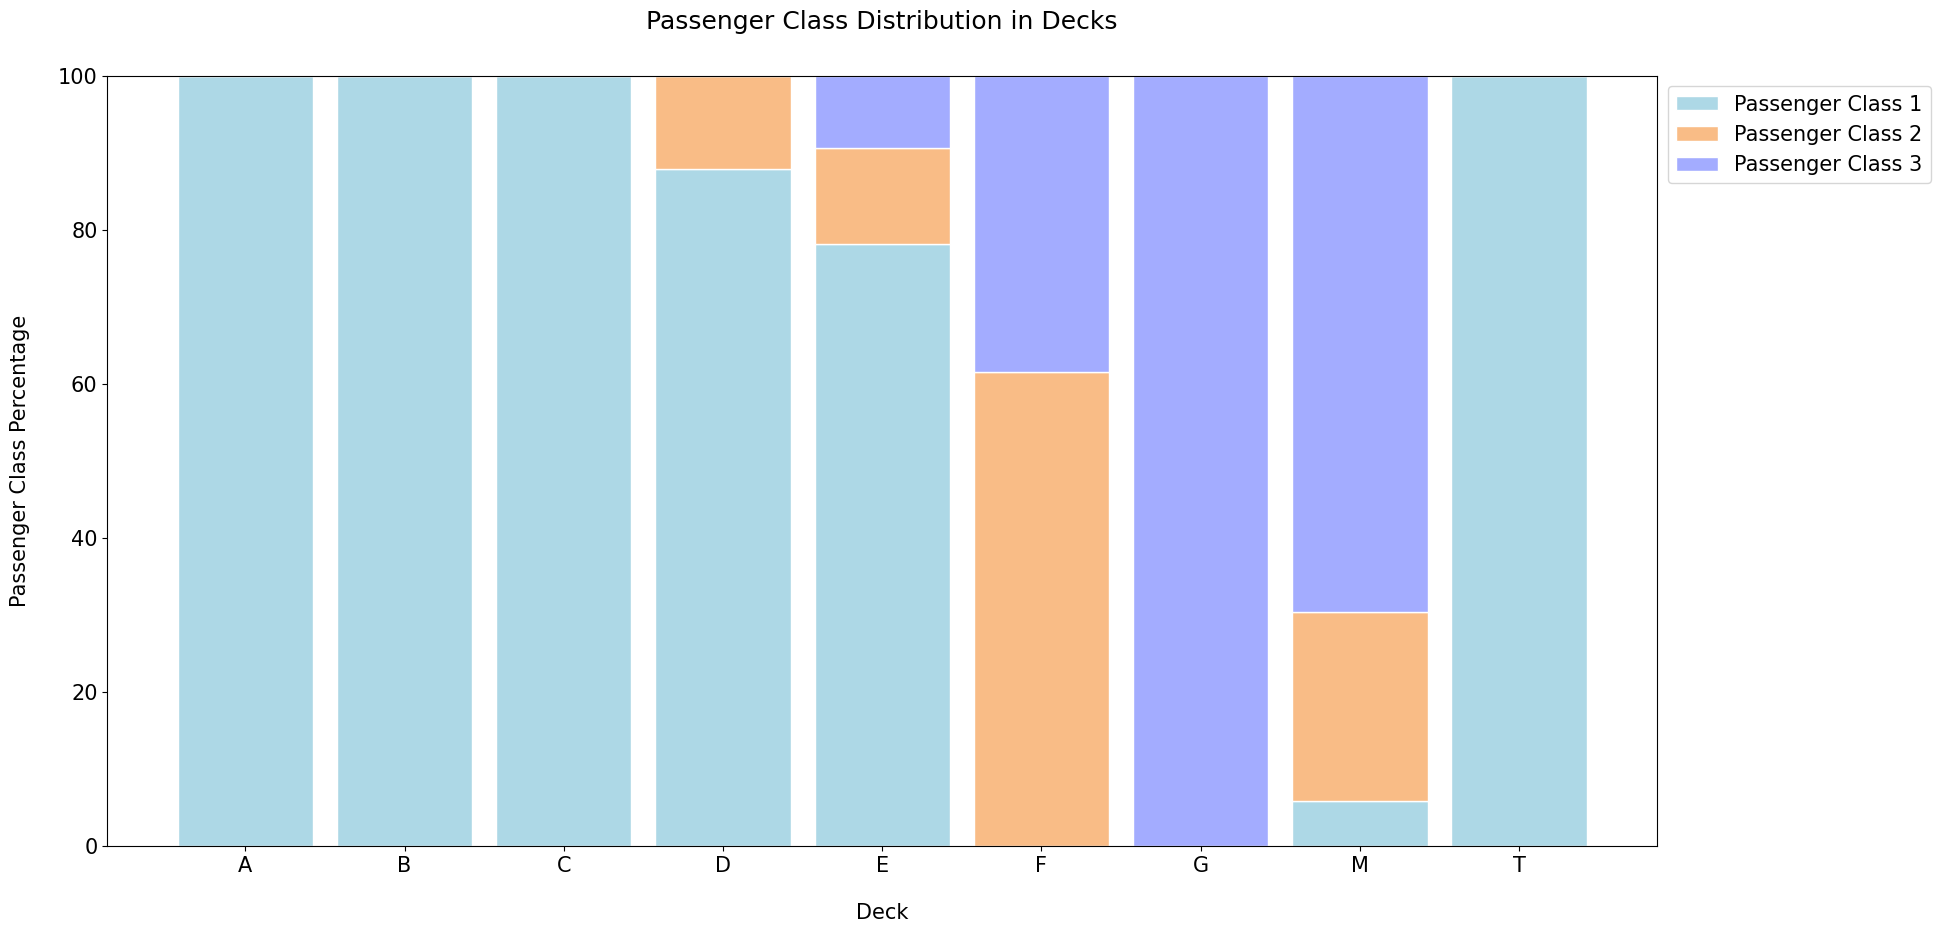

In [17]:
# # Creating Deck column from the first letter of the Cabin column (M stands for Missing)
# df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
#                                                                         'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='lightblue', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

* **100%** of **A**, **B** and **C** decks are 1st class passengers
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers
* **100%** of **G** deck are 3rd class passengers
* There is one person on the boat deck in **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers so he is grouped with **A** deck
* Passengers labeled as **M** are the missing values in `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so I decided to use **M** like a deck

In [18]:
# Passenger in the T deck is changed to A
idx = df_train[df_train['Deck'] == 'T'].index
df_train.loc[idx, 'Deck'] = 'A'

In [19]:
df_all_decks_survived = df_train.groupby(['Deck', 'Survived']).count()
df_all_decks_survived

PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  \
Deck Survived                                                              
A    0                   9       9     9    9    9      9      9       9   
     1                   7       7     7    7    7      7      7       7   
B    0                  12      12    12   12   12     12     12      12   
     1                  35      35    35   35   35     35     35      35   
C    0                  24      24    24   24   24     24     24      24   
     1                  35      35    35   35   35     35     35      35   
D    0                   8       8     8    8    8      8      8       8   
     1                  25      25    25   25   25     25     25      25   
E    0                   8       8     8    8    8      8      8       8   
     1                  24      24    24   24   24     24     24      24   
F    0                   5       5     5    5    5      5      5       5   
     1                   8       8     8    8    8      8      8       8   
G    0                   2       2     2    2    2      2      2       2   
     1                   2       2     2    2    2      2      2       2   
M    0                 481     481   481  481  481    481    481     481   
     1                 206     206   206  206  206    206    206     206   

               Fare  Cabin  Embarked  
Deck Survived                         
A    0            9      9         9  
     1            7      7         7  
B    0           12     12        12  
     1           35     35        35  
C    0           24     24        24  
     1           35     35        35  
D    0            8      8         8  
     1           25     25        25  
E    0            8      8         8  
     1           24     24        24  
F    0            5      5         5  
     1            8      8         8  
G    0            2      2         2  
     1            2      2         2  
M    0          481      0       481  
     1          206      0       206

In [20]:
df_all_decks_survived = df_train.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()
df_all_decks_survived

Deck      A      B       C      D      E      F     G       M     
Survived  0  1   0   1   0   1  0   1  0   1  0  1  0  1    0    1
Count     9  7  12  35  24  35  8  25  8  24  5  8  2  2  481  206

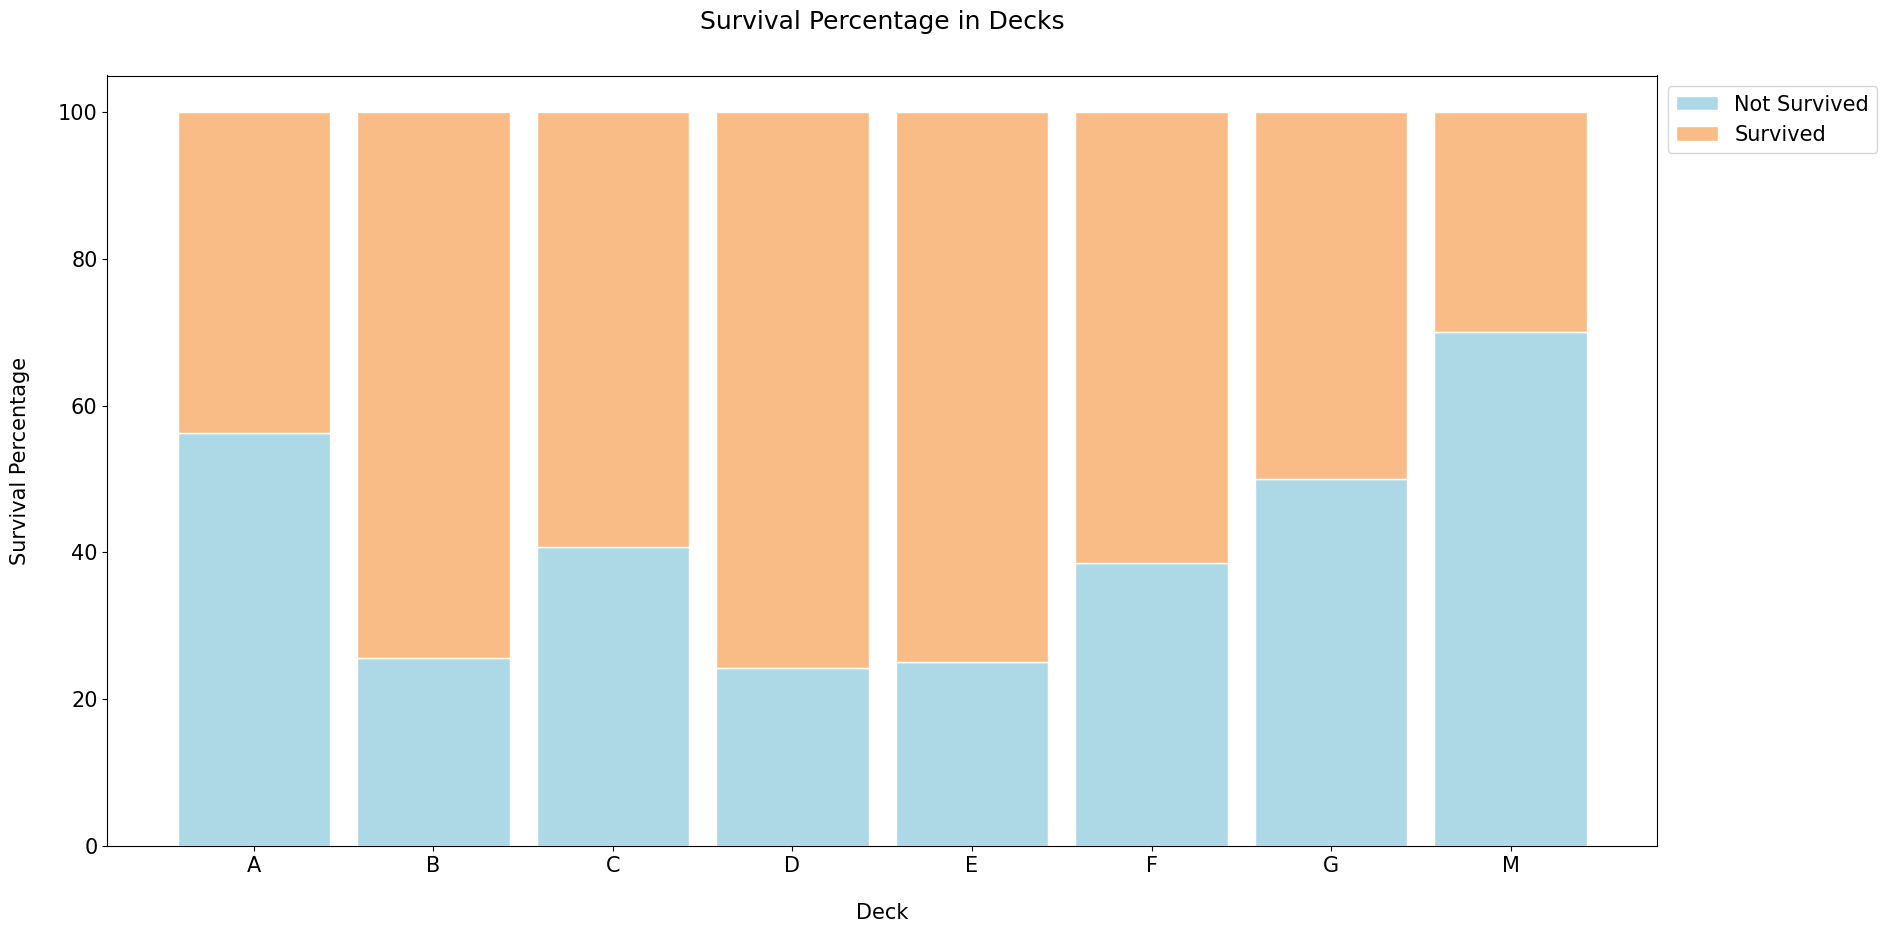

In [21]:
def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='lightblue', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

As I suspected, every deck has different survival rates and that information can't be discarded. Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with shared characteristics. `Deck` feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate
* **F** and **G** decks are labeled as **FG** because of the same reason above
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [22]:
df_train['Deck'] = df_train['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_train['Deck'] = df_train['Deck'].replace(['D', 'E'], 'DE')
df_train['Deck'] = df_train['Deck'].replace(['F', 'G'], 'FG')

df_train['Deck'].value_counts()

M      687
ABC    122
DE      65
FG      17
Name: Deck, dtype: int64

After filling the missing values in `Age`, `Embarked`, `Fare` and `Deck` features, there is no missing value left in both training and test set. `Cabin` is dropped because `Deck` feature is used instead of it.

In [23]:
# Dropping the Cabin feature
df_train.drop(['Cabin'], inplace=True, axis=1)
display_missing(df_train)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Embarked column missing values: 0
Deck column missing values: 0


### **1.3 Target Distribution**
* **38.38%** (342/891) of training set is **Class 1**
* **61.62%** (549/891) of training set is **Class 0**

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


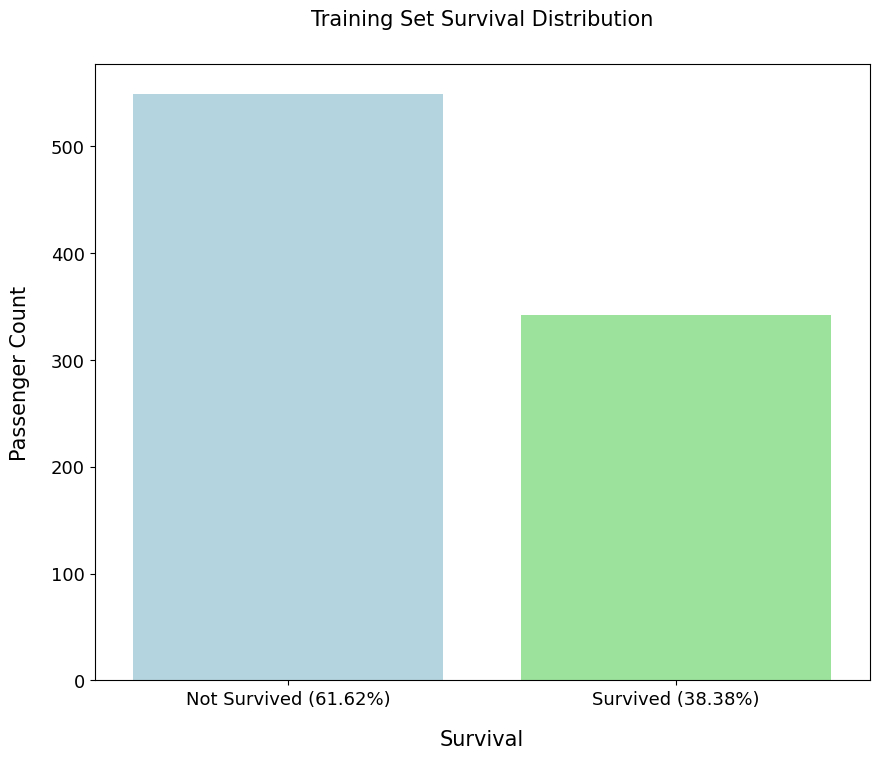

In [44]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]

survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(x='Survived', data = df_train, palette =['lightblue', 'lightgreen'] )

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### **1.4 Correlations**
Features are highly correlated with each other and dependent to each other. The highest correlation between features is **0.549500** in training set (between `Fare` and `Pclass`). The other features are also highly correlated. There are **9** correlations in training set that are higher than **0.1**.

In [47]:
#high correlations
df_corr.drop(df_corr.iloc[1::2].index, inplace=True)
df_corr = df_corr.drop(df_corr[df_corr['Correlation Coefficient'] == 1.0].index)

In [50]:
corr = df_corr['Correlation Coefficient']>0.1
df_corr[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,Pclass,Fare,0.549500
10,Parch,SibSp,0.414838
12,Age,Pclass,0.369226
14,Pclass,Survived,0.338481
16,Age,SibSp,0.308247
18,Survived,Fare,0.257307
20,Parch,Fare,0.216225
22,Parch,Age,0.189119
24,Fare,SibSp,0.159651


C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\2206212208.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})


<Axes: >

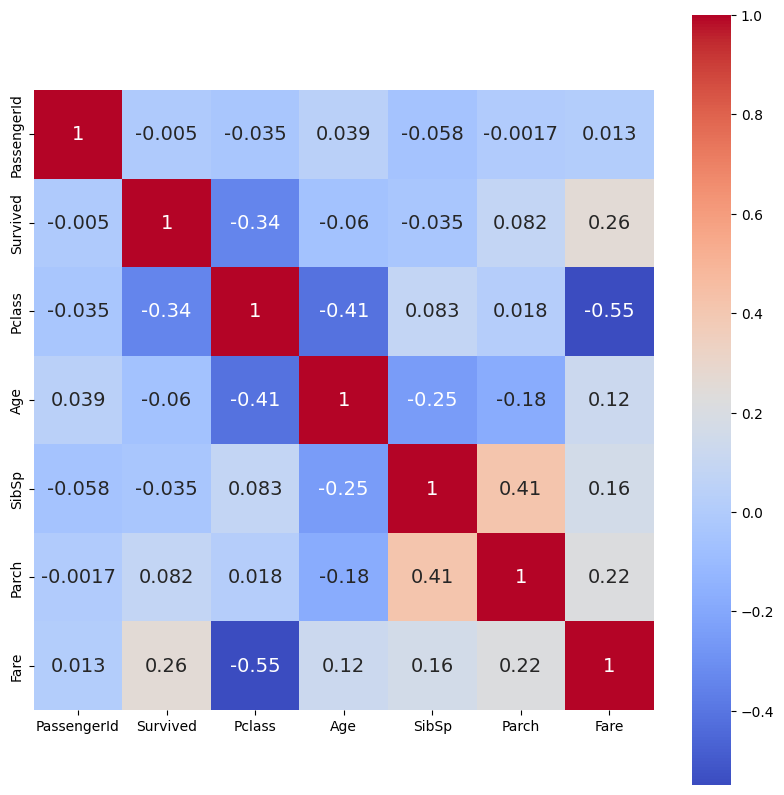

In [64]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

### **1.5 Target Distribution in Features**

#### **1.5.1 Continuous Features**
Both of the continuous features (`Age` and `Fare`) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.
​
* Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
* In distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\420745437.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\420745437.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe

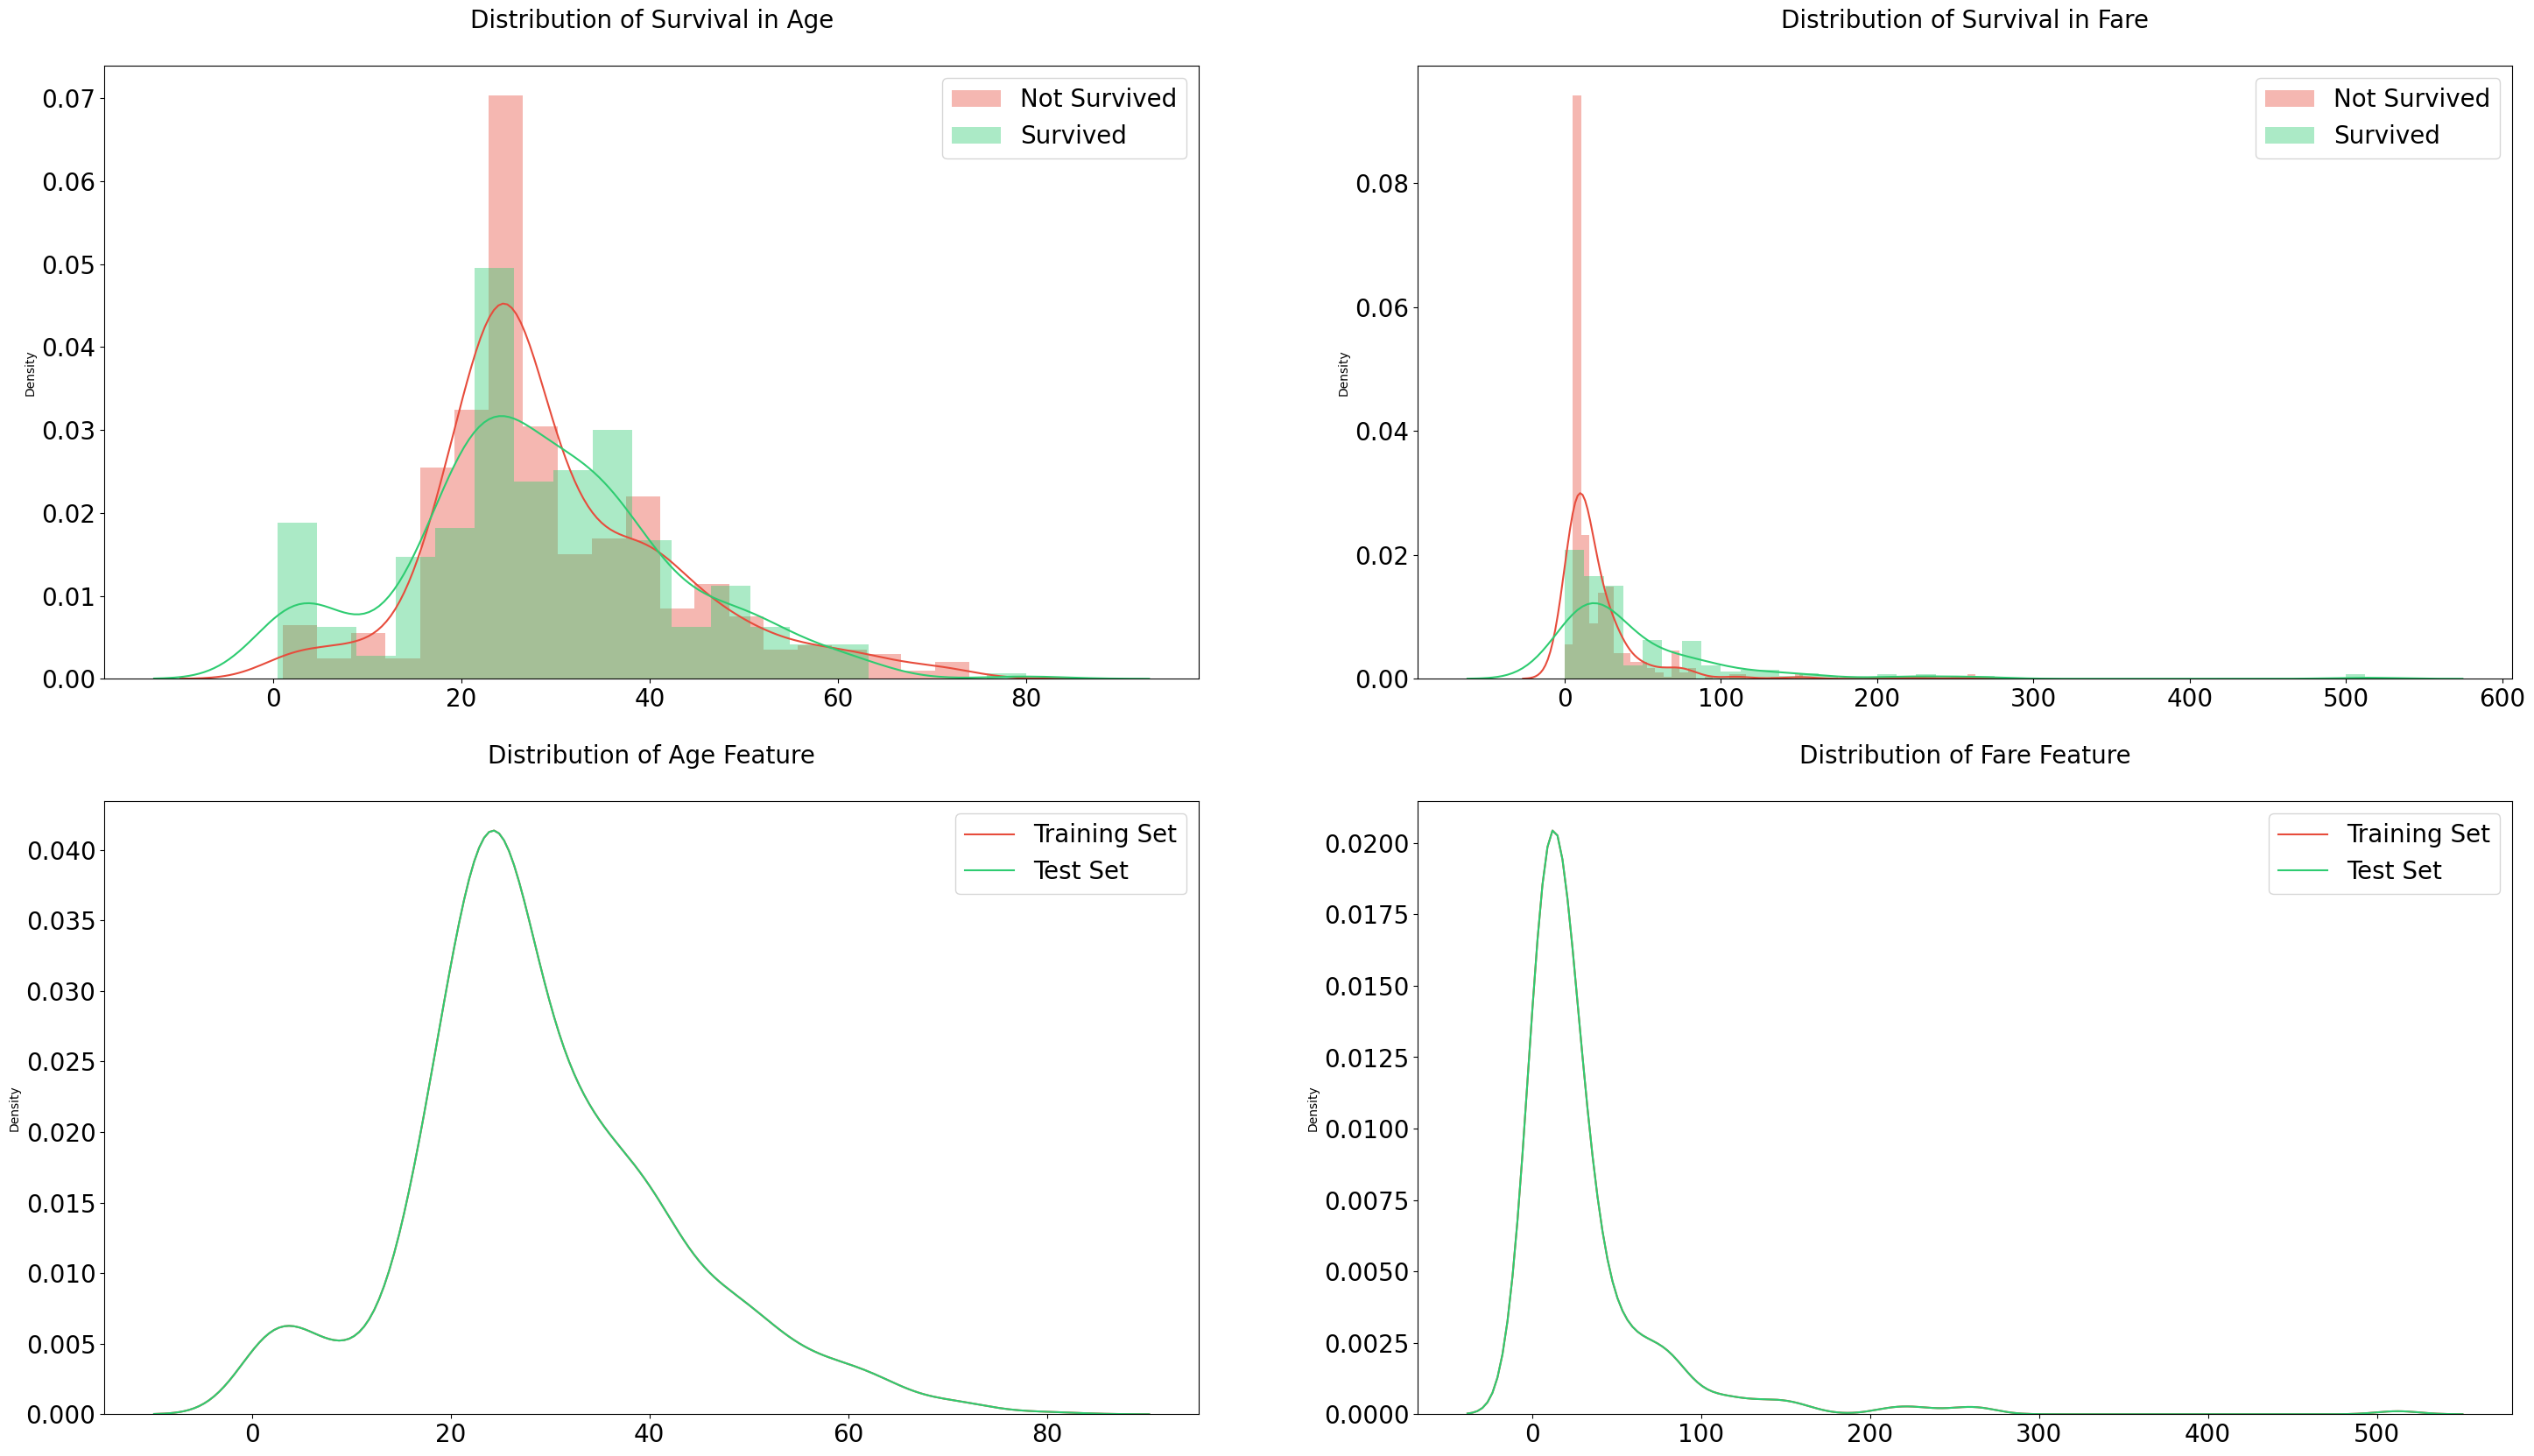

In [72]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_train[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

#### **1.5.2 Categorical Features**
Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are `Pclass` and `Sex` because they have the most homogenous distributions.
​
* Passengers boarded from **Southampton** has a lower survival rate unlike other ports. More than half of the passengers boarded from **Cherbourg** had survived. This observation could be related to `Pclass` feature
* `Parch` and `SibSp` features show that passengers with only one family member has a higher survival rate

C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\451393972.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i)
C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\451393972.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i)
C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\451393972.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i)
C:\Users\Legion\AppData\Local\Temp\ipykernel_19092\451393972.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly cal

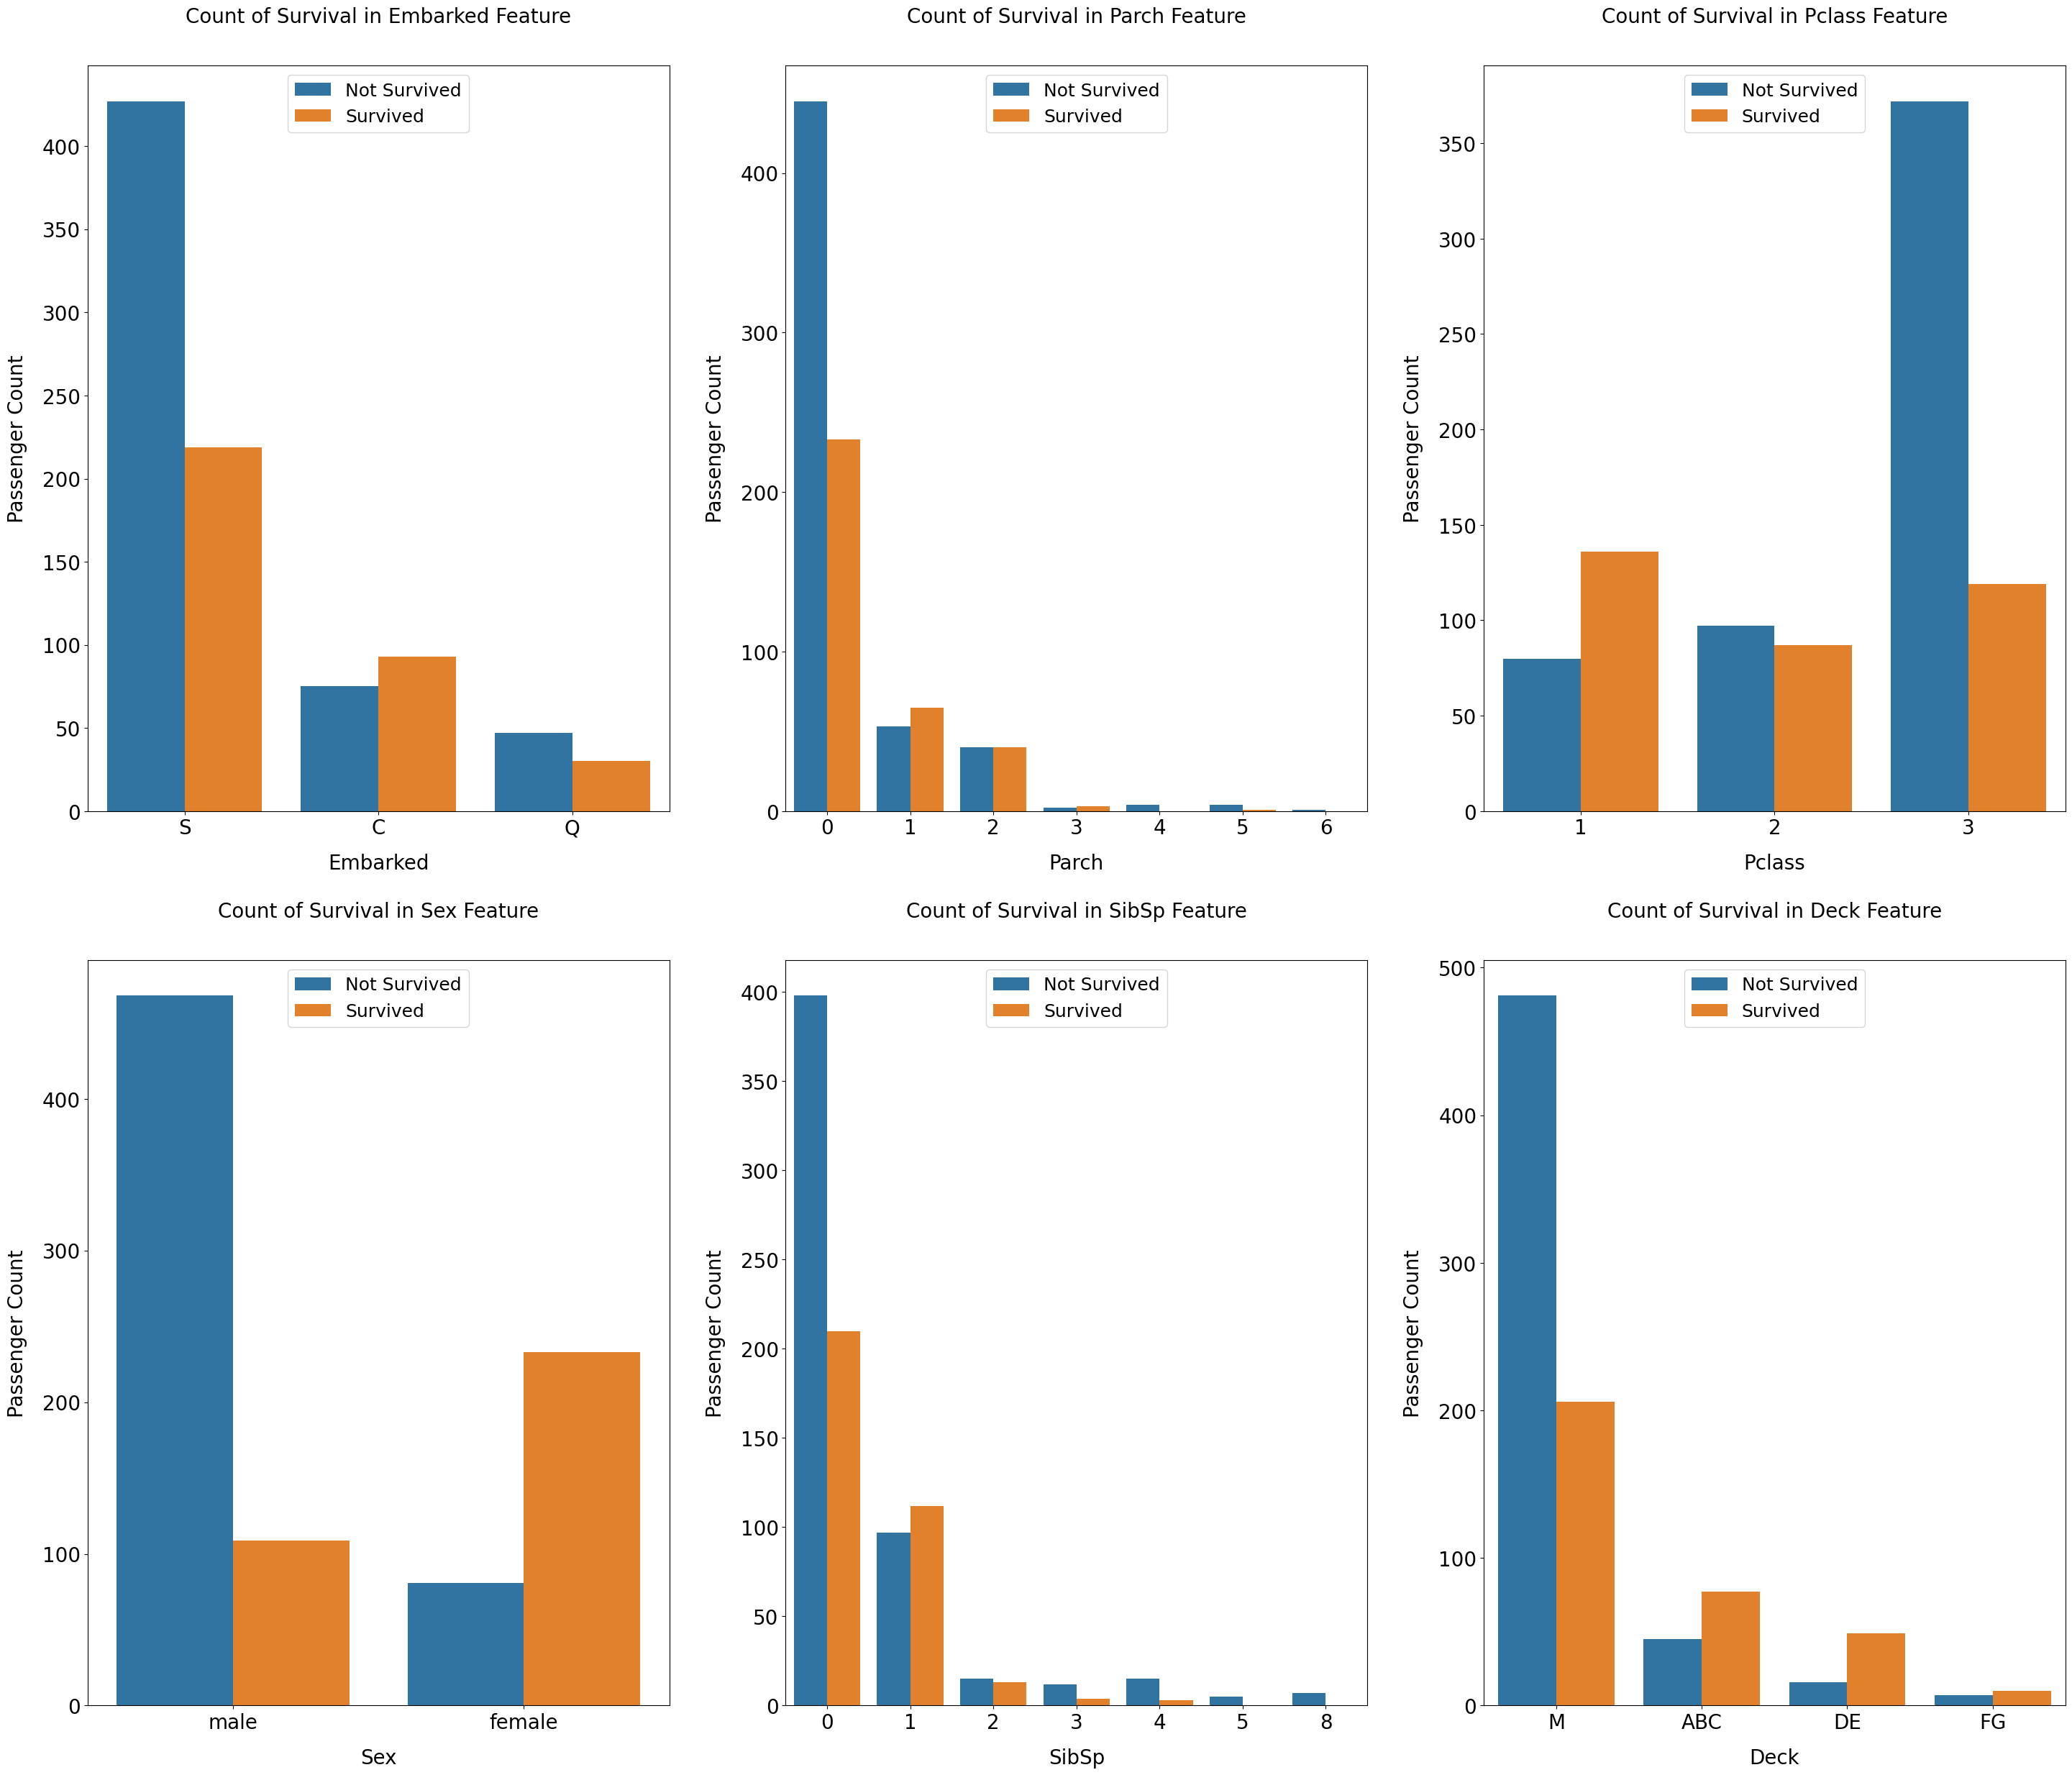

In [73]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

### **1.6 Conclusion**
Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with `Survived` feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called `Deck` and dropped `Cabin` feature at the **Exploratory Data Analysis** part.